Qualitatively compare the decision boundaries learnt by supervised and unsupervised methods on the FRB dataset

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
import sys
sys.path.append('src')
import numpy as np


from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import SVC

def decision_function(self, X):
    return self.predict_proba(X)[:,1] #prob scores for class 1 

MLPClassifier.decision_function = decision_function
GaussianNB.decision_function = decision_function
AdaBoostClassifier.decision_function = decision_function
RandomForestClassifier.decision_function = decision_function
SVC.decision_function = decision_function

from pca_frb import PCA_Classifier

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from SemiSupervisedClassifier import SemiSupervisedClassifier

In [2]:
with open("frb_datasets/ninjector_snr_dm_w.dat") as f:
    data_file = [[float(field) for field in line.strip().split(' ')] for line in f]
    
all_data = np.array(data_file, dtype=np.float32)

#remove all frbs from the dataset: we only want to train the encoder on noise, in order to detect outliers 

X = all_data[:,:-1] #remove the class label and nn score from the training data 
Y = all_data[:,-1].astype(np.int) #class labels
    

In [3]:
from sklearn.preprocessing import maxabs_scale
def visualise_boundary(clf, X, Y, axes,cmap_contour = plt.cm.hot, cmap_classes = plt.cm.PiYG, marker = 'o', markersize = 4):
    h = 0.05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    clf.fit(X,Y)
    Z = clf.decision_function( np.c_[xx.ravel(), yy.ravel()] )
    #scale Z to the range [0,1] (not all methods have this)
    Z = maxabs_scale(Z)
    Z = Z.reshape(xx.shape)
    axes.contourf(xx, yy, Z, cmap=cmap_contour, alpha=0.7, countours = 20)
    neg = X[Y == 0]
    pos = X[Y == 1]
    axes.scatter(neg[:, 0], neg[:, 1], c='blue', s=markersize, marker = 'x', edgecolors='none')
    axes.scatter(pos[:, 0], pos[:, 1], c='green', s=markersize, marker = 'o', edgecolors='none')

/usr/local/lib/python2.7/dist-packages/sklearn/covariance/robust_covariance.py:161: RuntimeWarning: Warning! det > previous_det (-20.396086254553431 > -20.433622545886987)
  % (det, previous_det), RuntimeWarning)


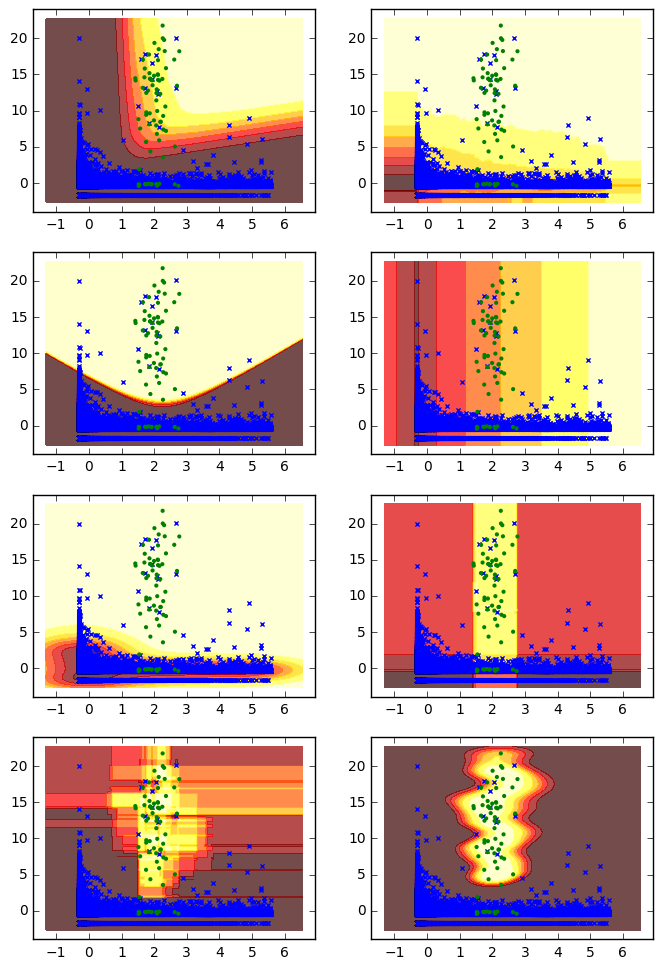

In [5]:
dm_snr = X[:,[1,0]]
scaled_dm_snr = StandardScaler().fit_transform(dm_snr)
plt.rcParams['figure.figsize'] = 8,12
classifiers = [MLPClassifier(),
               SemiSupervisedClassifier(IsolationForest(max_samples = 8000)),
               GaussianNB(),
               SemiSupervisedClassifier(EllipticEnvelope()),
               SemiSupervisedClassifier(OneClassSVM(nu=0.1)),
               AdaBoostClassifier(),
               RandomForestClassifier(),
               SVC(probability=True),
              ]

cols = 2
rows = int(np.ceil ((1.0 * len(classifiers) / cols) ))
fig, axtup = plt.subplots(rows, cols)

import itertools

for clf, axes in itertools.izip(classifiers, itertools.chain.from_iterable(axtup)):
    visualise_boundary(clf,scaled_dm_snr, Y, axes, cmap_classes = plt.cm.Dark2, markersize = 9)

The above plots visualise the decision boundaries learnt by classifiers trained on the snr and dm only. They should not be taken as authoritative since there is an additional dimension in use (the boxcar width) but they provide a qualitative picture of how the classifiers operate. The hotter colours represent areas of the space the classifier assigns higher probability of being an FRB/outlier. The blue crosses are noise observations, and the green dots are (simulated) FRB candidates. Note the much wider area of possible outliers which is covered by the unsupervised methods, wheras the supervised all tend to hug the data closely

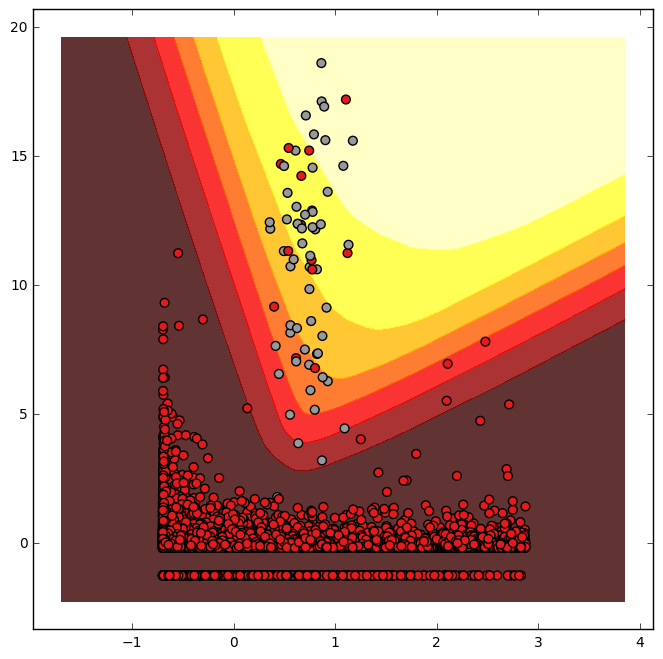

In [6]:
visualise_boundary(MLPClassifier(), scaled_dm_snr, Y)

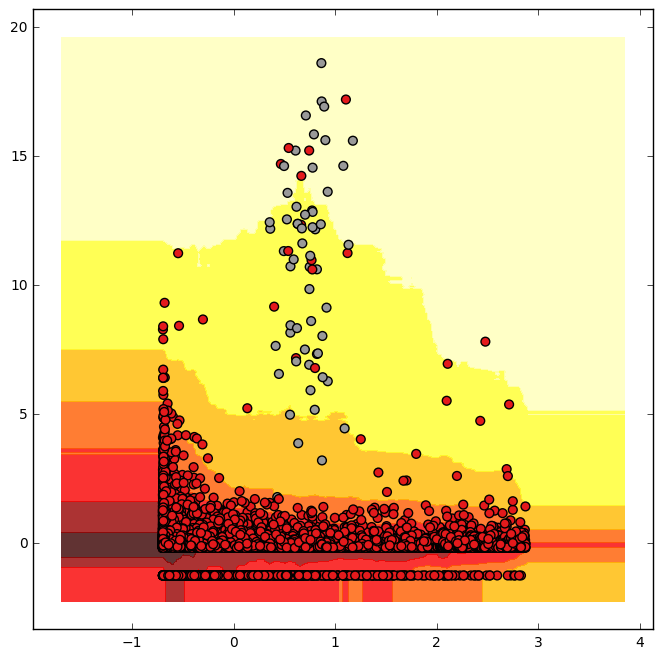

In [7]:
visualise_boundary(SemiSupervisedClassifier(IsolationForest(max_samples = 8000)), scaled_dm_snr, Y)

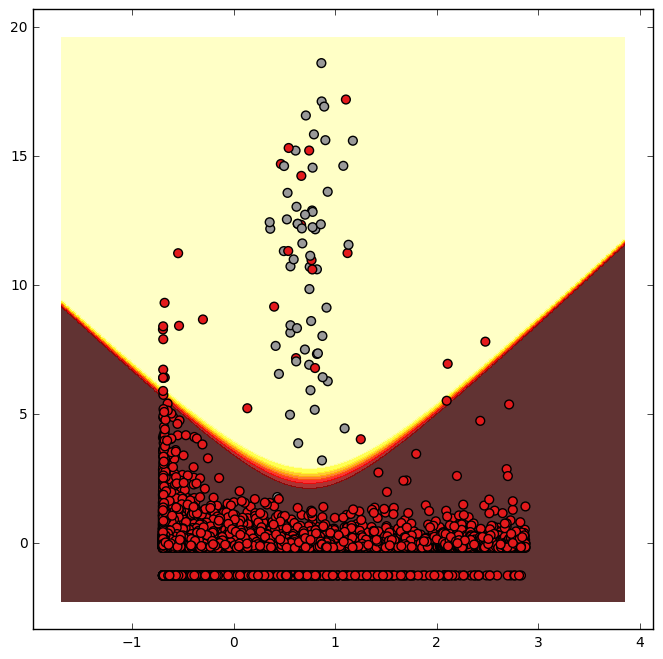

In [16]:
visualise_boundary(GaussianNB(), scaled_dm_snr, Y)

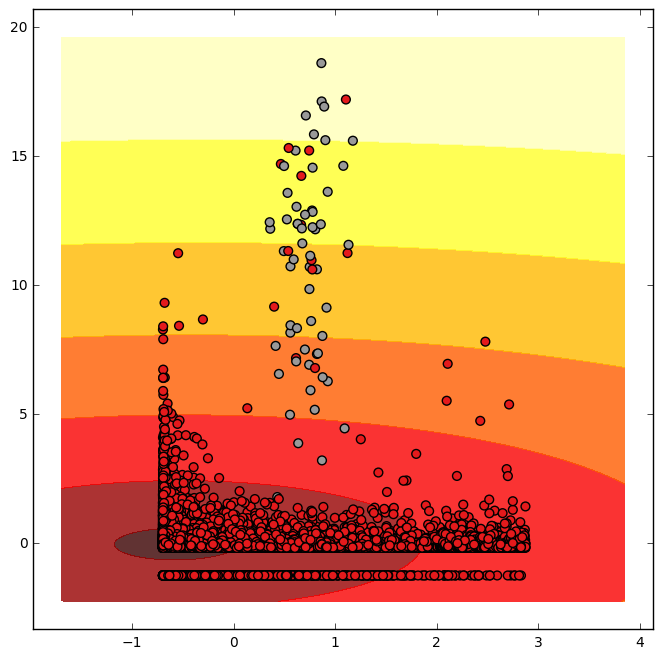

In [18]:
visualise_boundary(SemiSupervisedClassifier(EllipticEnvelope()), scaled_dm_snr, Y)

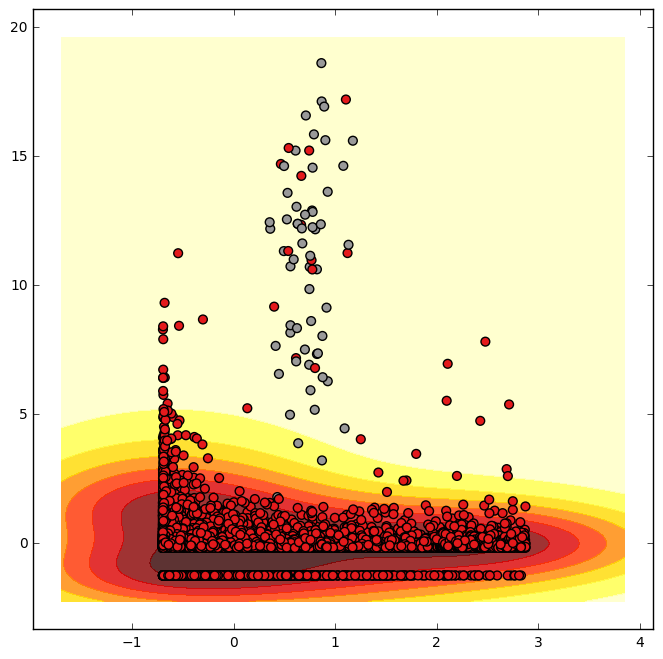

In [21]:
visualise_boundary(SemiSupervisedClassifier(OneClassSVM(nu=0.1)), scaled_dm_snr, Y)

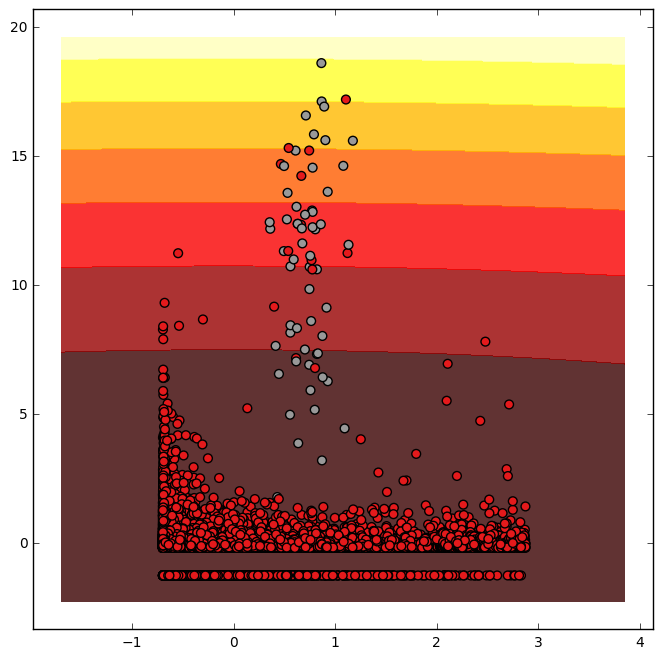

In [25]:
visualise_boundary(PCA_Classifier(), scaled_dm_snr, Y)

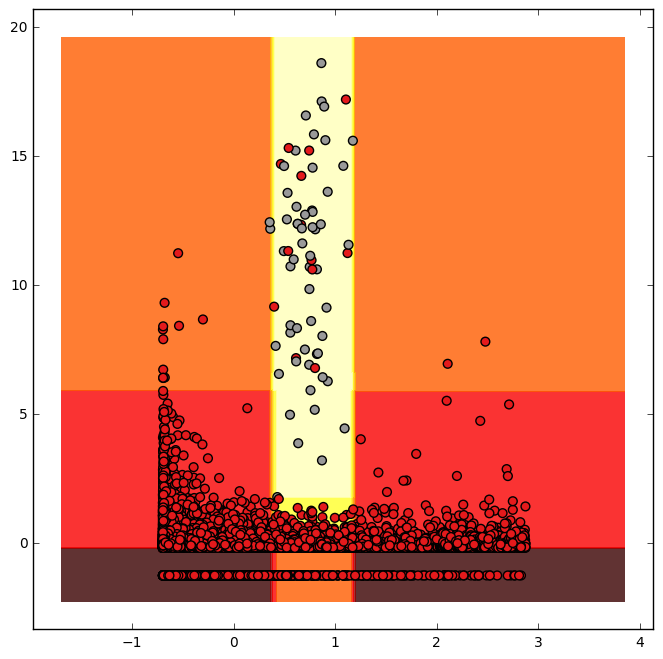

In [8]:
visualise_boundary(AdaBoostClassifier(), scaled_dm_snr, Y)

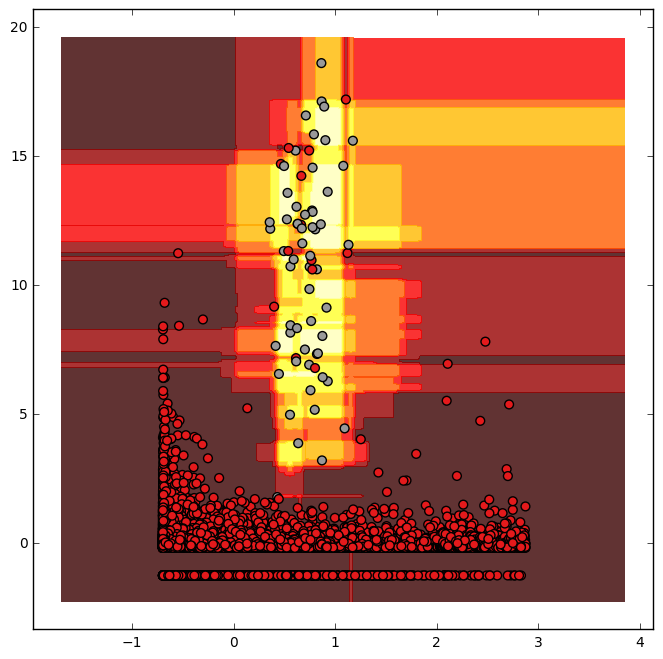

In [11]:
visualise_boundary(RandomForestClassifier(), scaled_dm_snr, Y)

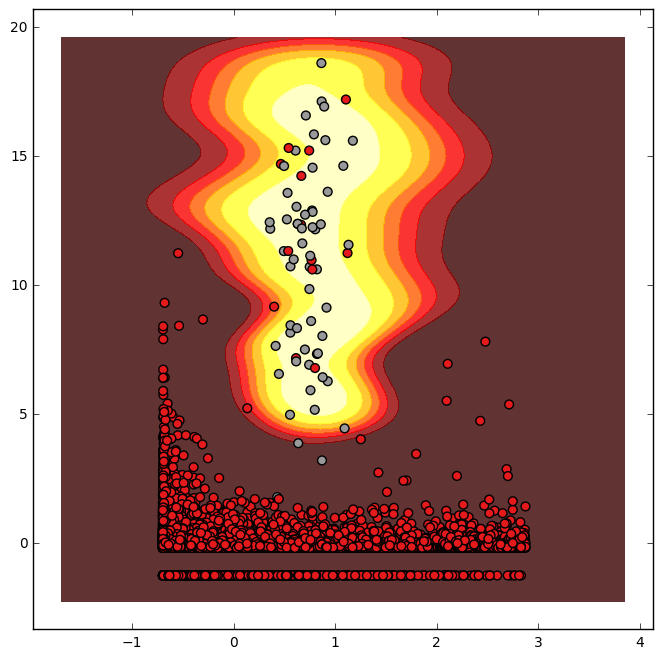

In [15]:
visualise_boundary(SVC(probability=True), scaled_dm_snr, Y)